In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from esense_package.data_tool import Dataset, DataGenerator
import numpy as np
from esense_package.visualize import plot_instances
from esense_package.models import Model
from tensorflow.keras.utils import to_categorical
from esense_package.evaluate_tool import get_confusionmatrix, get_derived_mucosal, get_classification_report, derive_mucosal
from esense_package.data_tool import mucous_activity_label_list, non_mucous_activity_label_list

## Train with video and guided using full window

IMU data sorted
Label replaced
Training instance: 581
Test instance: 194


2022-06-15 14:33:09.666677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-15 14:33:10.095215: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22302 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:41:00.0, compute capability: 8.6
2022-06-15 14:33:11.387561: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301
2022-06-15 14:33:12.297714: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


7/7 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       108
           1       0.71      0.70      0.71        86

    accuracy                           0.74       194
   macro avg       0.74      0.74      0.74       194
weighted avg       0.74      0.74      0.74       194



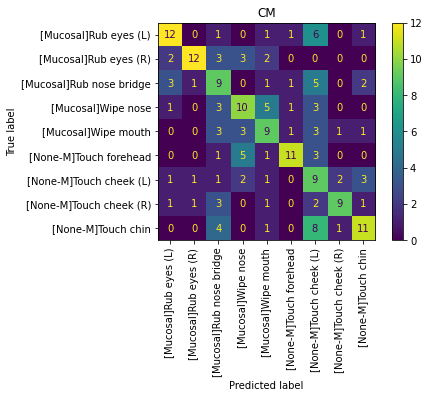

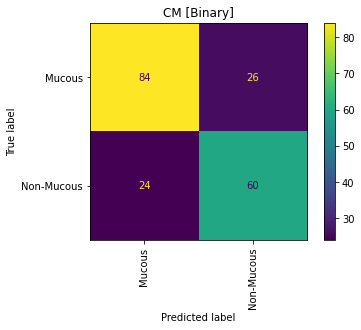

In [2]:
# Data creation
verbose, epochs, batch_size = 0, 20, 32
dataset = Dataset(imu_file_name = '/data1/esense/IMU_20220408_1.5s.csv', label_file_name = "/data1/esense/facetouch_imu_sorted_for_timing_label_20220217_combine.xlsx")
dataset.filter_source_session(source=['video'], session=[2, 3])
dataset.deploy_train_test_split(0.2)
train_df = dataset.get_train_df()
test_df = dataset.get_test_df()
train_dg = DataGenerator(train_df)
test_dg = DataGenerator(test_df)

train_dg.reset()
test_dg.reset()
data_length = 380 ## adjust this
step_size = 0 # window step 0.1s
window_num = 1 # number of sliding windows
train_dg.generate_data(data_length = data_length, step_size = step_size, window_num = window_num, 
                        data_following_length = int((step_size * window_num)*1.5))
test_dg.generate_data(data_length = data_length, step_size = step_size, window_num = window_num, 
                        data_following_length = int((step_size * window_num)*1.5))

trainX, trainy, trainy_bi = train_dg.get_list_for_classification()
testX, testy, testy_bi = test_dg.get_list_for_classification()

testX, testy, testy_bi = np.array(testX), to_categorical(np.array(testy)), to_categorical(np.array(testy_bi))
trainX, trainy, trainy_bi = np.array(trainX), to_categorical(np.array(trainy)), to_categorical(np.array(trainy_bi))

print(f'Training instance: {len(trainX)}')
print(f'Test instance: {len(testX)}')


n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Model('None')
model.init_classification_model((n_timesteps,n_features), n_outputs)
# model.print_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)

y_pred = model.predict(testX)

get_confusionmatrix(y_pred, testy, mucous_activity_label_list + non_mucous_activity_label_list, 'CM')

get_derived_mucosal(y_pred, testy, 'CM [Binary]')

y_pred_mucosal, y_true_mucosal = derive_mucosal(y_pred, testy)
print(get_classification_report(y_pred_mucosal, y_true_mucosal))

## Using 1.2s sliding window

IMU data sorted
Label replaced
Training instance: 2383
Test instance: 837
27/27 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.74      0.65      0.69       581
           1       0.38      0.48      0.42       256

    accuracy                           0.60       837
   macro avg       0.56      0.57      0.56       837
weighted avg       0.63      0.60      0.61       837



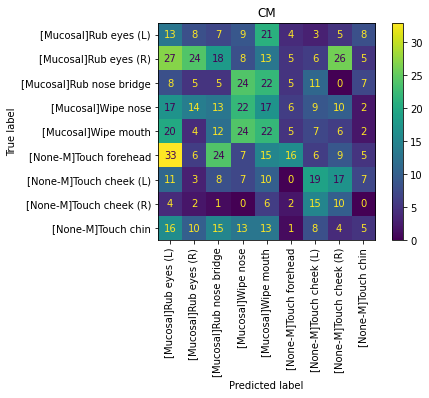

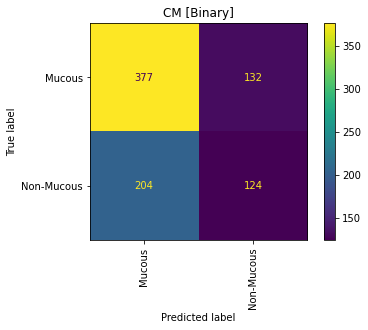

In [3]:
# Data creation
verbose, epochs, batch_size = 0, 20, 32
dataset = Dataset(imu_file_name = '/data1/esense/IMU_20220408_1.5s.csv', label_file_name = "/data1/esense/facetouch_imu_sorted_for_timing_label_20220217_combine.xlsx")
dataset.filter_source_session(source=['video'], session=[2, 3])
dataset.deploy_train_test_split(0.2)
train_df = dataset.get_train_df()
test_df = dataset.get_test_df()
train_dg = DataGenerator(train_df)
test_dg = DataGenerator(test_df)

train_dg.reset()
test_dg.reset()
data_length = 120 ## adjust this
step_size = 5 # window step 0.1s
window_num = 10 # number of sliding windows
train_dg.generate_data(data_length = data_length, step_size = step_size, window_num = window_num, 
                        data_following_length = int((step_size * window_num)*1.5))
test_dg.generate_data(data_length = data_length, step_size = step_size, window_num = window_num, 
                        data_following_length = int((step_size * window_num)*1.5))

trainX, trainy, trainy_bi = train_dg.get_list_for_classification()
testX, testy, testy_bi = test_dg.get_list_for_classification()

testX, testy, testy_bi = np.array(testX), to_categorical(np.array(testy)), to_categorical(np.array(testy_bi))
trainX, trainy, trainy_bi = np.array(trainX), to_categorical(np.array(trainy)), to_categorical(np.array(trainy_bi))

print(f'Training instance: {len(trainX)}')
print(f'Test instance: {len(testX)}')


n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Model('None')
model.init_classification_model((n_timesteps,n_features), n_outputs)
# model.print_model()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)

y_pred = model.predict(testX)

get_confusionmatrix(y_pred, testy, mucous_activity_label_list + non_mucous_activity_label_list, 'CM')

get_derived_mucosal(y_pred, testy, 'CM [Binary]')

y_pred_mucosal, y_true_mucosal = derive_mucosal(y_pred, testy)
print(get_classification_report(y_pred_mucosal, y_true_mucosal))